In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.diagnostic import het_white
from statsmodels.iolib.summary2 import summary_col

import scipy
import scipy.stats as stat
from scipy.stats.distributions import gamma
from scipy.stats import kendalltau


from joypy import joyplot

from functools import reduce

from functions import *

C:\Users\adria\AppData\Local\Temp\ipykernel_16196\246975071.py:17: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import kendalltau


# Import Datasets
## Fish

In [2]:
fish = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Observational\Marine Institute\Atlantic salmon\Processed\juvenile_atlantic_salmon_2023-05-30.csv', parse_dates = ['date'])
fish = fish[(fish.lengthmm.notna())&(fish.cohort <=2019)]
fish

,cohort,date,age,dayofyear,lengthmm,river,age_class
0,1997,1997-11-23,337,327,68.0,Roug,0
1,1997,1997-11-23,337,327,70.0,Roug,0
2,1997,1997-11-25,339,329,68.0,Roug,0
3,1997,1997-12-08,352,342,71.0,Roug,0
4,1997,1997-12-08,352,342,60.0,Roug,0
...,...,...,...,...,...,...,...
35714,2017,2019-06-18,909,169,129.0,Sea-entry,2
35715,1995,1996-09-25,644,269,79.0,Roug,1
35716,1995,1996-09-25,644,269,81.0,Roug,1
35717,1995,1996-09-25,644,269,82.0,Roug,1


## Temperature

In [3]:
wt = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\Water_Temperature\Water_Temperature.csv', parse_dates=['date'], index_col = 0)
wt

,date,wt
365,1962-01-01,2.393565
366,1962-01-02,2.496376
367,1962-01-03,2.456608
368,1962-01-04,2.277996
369,1962-01-05,2.468114
...,...,...
21544,2019-12-27,5.978017
21545,2019-12-28,6.271645
21546,2019-12-29,6.285390
21547,2019-12-30,6.372072


# Timelines

In [4]:
def freshwater_residency(time_to_smolt, wt, fish = None):
    ''' 
    This function will make a complete timeline for each cohort
    '''
    from datetime import date, timedelta
    ### for future reference - years_to_smolt must be supplied before df
    cohort_list = []         # To store all potential cohorts
    date_list = []           # Store all dates belonging to the cohort (3 years) for Rough River
    age_list = []            # Get running age of fish from proxy spawning

    wt.set_index('date', inplace = True)

    for year in np.unique(wt.index.year):
        start_date = date(year-1, 12, 21)                   # Cohorts are assigned year for when they first appear in the dataset (usually the year following the spawning event)
        end_date = date(year+(time_to_smolt), 12, 31)        # Cohorts have different freshwater residency time, 3 in the Burrishoole and 4-6 in the Skjoma
        age = 0                                             # Have running dates from time of spawning
        for single_date in daterange(start_date, end_date):
            cohort_list.append(year)                                    # Store cohort = year in the list
            date_list.append(single_date.strftime('%Y-%m-%d'))          # Store date in the list
            age_list.append(age)                                        # Store day in the list
            linearised_cohorts = zip(cohort_list, date_list, age_list) # Merge lists
            age += 1                                                    # Increment day before next turn in the loop
    linearised_cohorts = pd.DataFrame(list(linearised_cohorts))
    linearised_cohorts = linearised_cohorts.rename(columns = {0:'cohort', 1: 'date', 2:'age'})
    linearised_cohorts.reset_index(inplace = True, drop = True)
    linearised_cohorts['date'] = pd.to_datetime(linearised_cohorts['date'])
    linearised_cohorts = pd.merge(linearised_cohorts, wt, on = ['date'], how = 'outer')
    linearised_cohorts = linearised_cohorts[linearised_cohorts.wt.notna()].reset_index(drop = True)
    if fish is not None: 
        linearised_cohorts['dd'] = linearised_cohorts.groupby('cohort').wt.cumsum()
        linearised_cohorts = pd.merge(linearised_cohorts, fish, on = ['cohort', 'date', 'age'], how = 'outer')
    else: 
        linearised_cohorts['dd'] = linearised_cohorts.groupby(['cohort', 'climate_scenario']).wt.cumsum()
    return(linearised_cohorts)


In [5]:
df = freshwater_residency(2, wt, fish)
df = df[(df.cohort >= 1963)&(df.cohort <= 2017)]
len(df[df.lengthmm.notna()])

35719

In [6]:
fish_gamma_inv_glm = smf.glm('lengthmm~dd', family = sm.families.Gamma() , data = df).fit()
fish_gamma_inv_glm.summary()

c:\Users\adria\.conda\envs\air_to_water\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               lengthmm   No. Observations:                35719
Model:                            GLM   Df Residuals:                    35717
Model Family:                   Gamma   Df Model:                            1
Link Function:          inverse_power   Scale:                        0.019476
Method:                          IRLS   Log-Likelihood:            -1.3273e+05
Date:                Fri, 16 Jun 2023   Deviance:                       695.35
Time:                        12:52:20   Pearson chi2:                     696.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9984
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0222   2.38e-05    931.375      0.000       0.022       0.022
dd         -1.752e-06   3.57e-09   -490.782      0.000   -1.76e-06   -1.75e-06
==============================================================================
"""

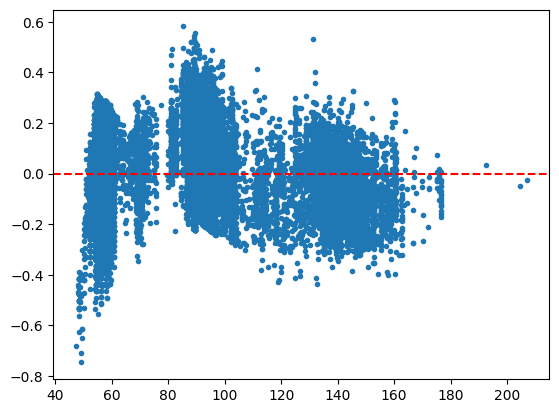

In [7]:
plt.plot(fish_gamma_inv_glm.fittedvalues, fish_gamma_inv_glm.resid_deviance, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

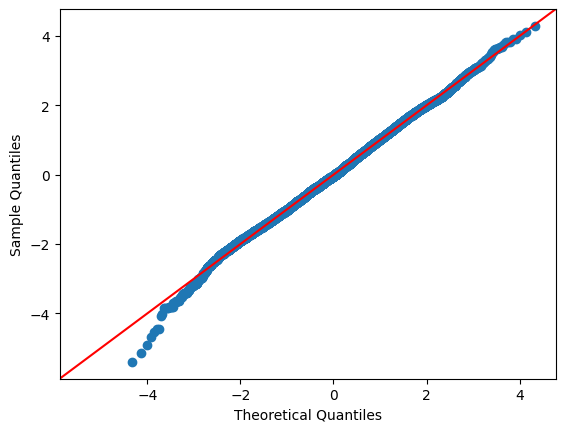

In [8]:
sm.qqplot(fish_gamma_inv_glm.resid_deviance, dist = scipy.stats.t, fit = True, line = '45');

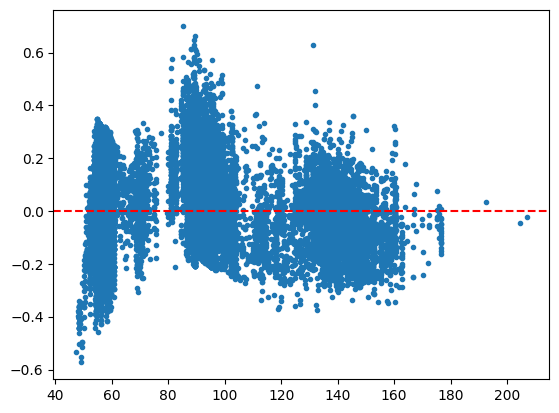

In [9]:
plt.plot(fish_gamma_inv_glm.fittedvalues, fish_gamma_inv_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

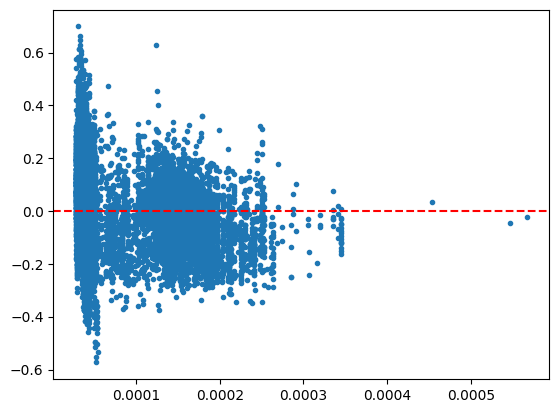

In [10]:
plt.plot(fish_gamma_inv_glm.get_influence().hat_matrix_diag, fish_gamma_inv_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

In [11]:
fish_gamma_log_glm = smf.glm('lengthmm~dd', family = sm.families.Gamma(sm.families.links.log()) , data = df) #df[(df.river != 'Sea-entry')]
fish_gamma_log_glm = fish_gamma_log_glm.fit(cov_type='HAC', cov_kwds = {'maxlags':df[df.lengthmm.isna()].dd.max().round().astype(int)})
fish_gamma_log_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               lengthmm   No. Observations:                35719
Model:                            GLM   Df Residuals:                    35717
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                        0.017110
Method:                          IRLS   Log-Likelihood:            -1.3057e+05
Date:                Fri, 16 Jun 2023   Deviance:                       616.23
Time:                        12:52:24   Pearson chi2:                     611.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9994
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6464      0.011    345.740      0.000       3.626       3.667
dd             0.0001   2.34e-06     62.328      0.000       0.000       0.000
==============================================================================
"""

In [12]:
fish_gamma_log_glm.params

Intercept    3.646410
dd           0.000146
dtype: float64

In [13]:
fish_gamma_log_glm.params[1]

0.00014579626795429597

In [14]:
fish_gamma_log_glm.bse

Intercept    0.010547
dd           0.000002
dtype: float64

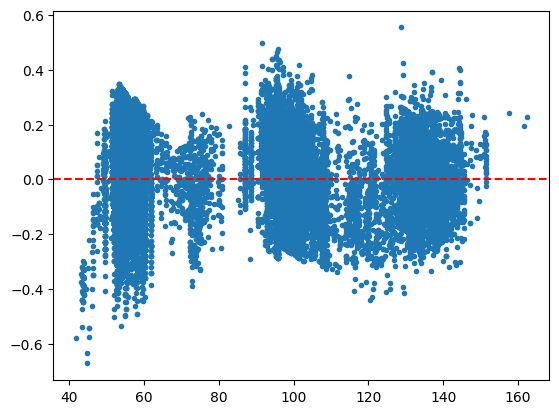

In [15]:
plt.plot(fish_gamma_log_glm.fittedvalues, fish_gamma_log_glm.resid_deviance, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

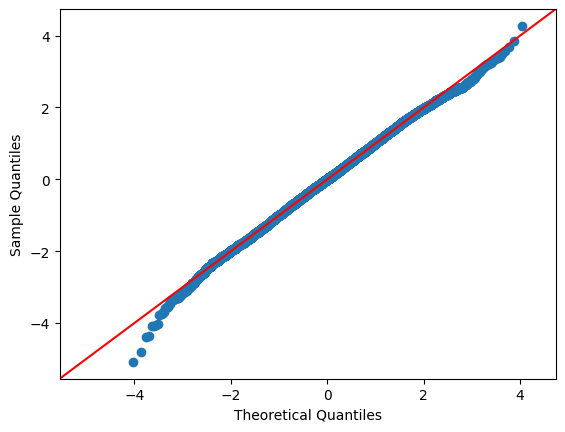

In [16]:
sm.qqplot(fish_gamma_log_glm.resid_deviance, dist = scipy.stats.t, fit = True, line = '45');

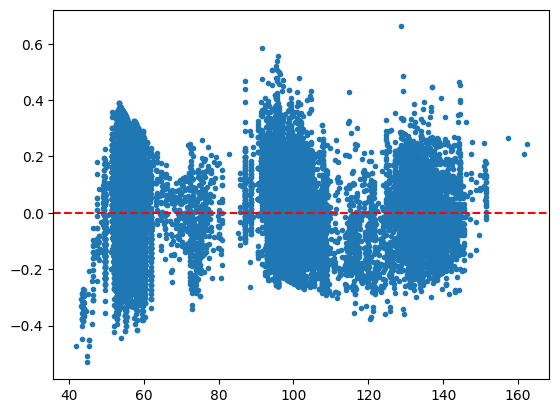

In [17]:
plt.plot(fish_gamma_log_glm.fittedvalues, fish_gamma_log_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

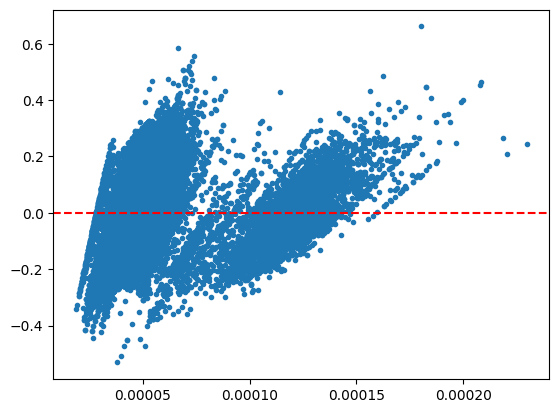

In [18]:
plt.plot(fish_gamma_log_glm.get_influence().hat_matrix_diag, fish_gamma_log_glm.resid_pearson, '.')
plt.axhline(0, color = 'red', linestyle = 'dashed')

# Visualise the Fit

In [19]:
beta_samp_mean = fish_gamma_log_glm.params
beta_samp_cov = fish_gamma_log_glm.cov_params()
dispersion = fish_gamma_log_glm.scale

X_pred = np.linspace(0, 10000, 10000)
X_pred = sm.tools.add_constant(X_pred)

num_samps = 50000
possible_coefficients = np.random.multivariate_normal(mean = beta_samp_mean, cov = beta_samp_cov, size = num_samps)
linear_predictions = [X_pred@b for b in possible_coefficients]

y_hyp = gamma(a=1/dispersion, scale = np.exp(linear_predictions, order = 'K')*dispersion).rvs()

l, u = np.quantile(y_hyp, q = [0.025, 0.975], axis = 0)

KeyboardInterrupt: 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


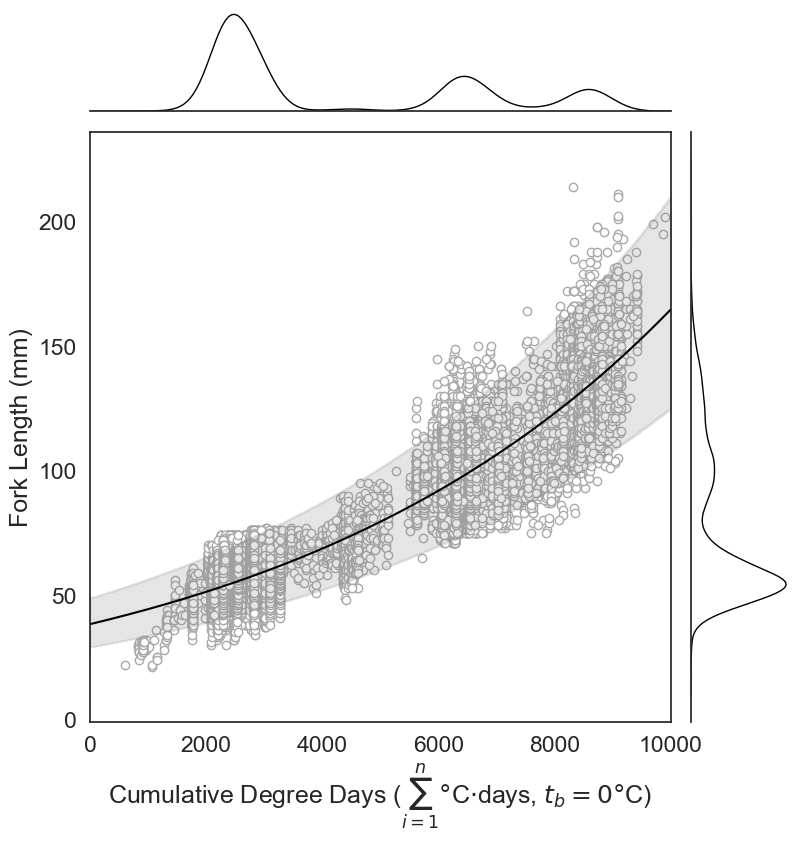

In [ ]:
from matplotlib.pyplot import cm

sns.set_theme(style = 'white', font_scale = 1.5)

graph = sns.JointGrid(xlim = (0, 10000), height = 8)
x, y= df[(df.lengthmm.notna())]['dd'], df[(df.lengthmm.notna())]['lengthmm']
graph.ax_joint.scatter(x, y, color = 'white', edgecolor = 'darkgray')
sns.kdeplot(y = y, ax = graph.ax_marg_y, color = 'black', linewidth = 1)
sns.kdeplot(x = x, ax = graph.ax_marg_x, color = 'black', linewidth = 1)
XX = pd.DataFrame({'dd': np.arange(0, 10000)})

#graph.ax_joint.plot(XX_new.dd, fish_gamma_inv_glm.predict(XX_new), color = 'black')
#color = iter(cm.rainbow(np.linspace(0, 1, len(XX_new.river.unique()))))
#for river in XX_new.river.unique():
#    c = next(color)
#    fish_gamma_log_glm.predict(XX_new[XX_new.river == river])
graph.ax_joint.plot(XX.dd, fish_gamma_log_glm.predict(XX), color = 'black')
graph.ax_joint.fill_between(X_pred[:, 1], l, u, color = 'gray', alpha = 0.2)
graph.set_axis_labels(xlabel = r'Cumulative Growing Degree Days ($\sum^{n}_{i=1}$$\degree$C$\cdot$days, $t_b = 0 \degree$C)', ylabel = r'Fork Length (mm)')
sns.despine(ax = graph.ax_joint, right = False, left = False, bottom = False, top = False)
sns.despine(ax = graph.ax_marg_x, right = True, left = True, bottom = False, top = True)
sns.despine(ax = graph.ax_marg_y, right = True, left = False, bottom = True, top = True)

#plt.savefig('Figures\EPS\Growth-Model.eps', dpi = 600, bbox_inches="tight")
#plt.savefig('Figures\Growth-Model.tiff', dpi = 600, bbox_inches="tight")

In [ ]:
df['lengthmm_pred'] = fish_gamma_log_glm.predict(df)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


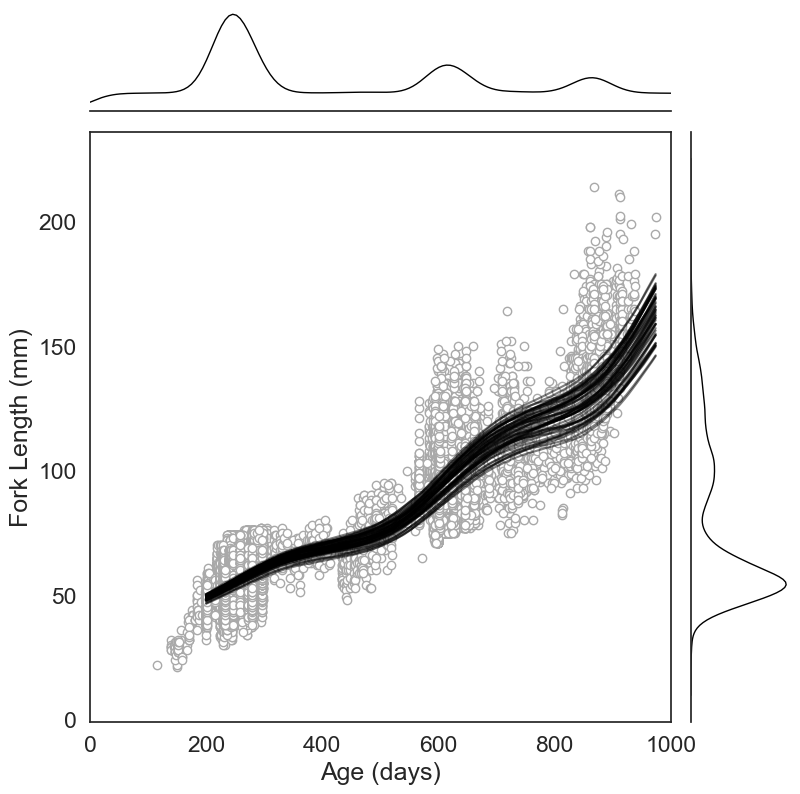

In [ ]:
from matplotlib.pyplot import cm

sns.set_theme(style = 'white', font_scale = 1.5)

graph = sns.JointGrid(xlim = (0, 1000), height = 8)
x, y, z, = df['age'], df['lengthmm'], df['lengthmm_pred']
graph.ax_joint.scatter(x, y, color = 'white', edgecolor = 'darkgray')
sns.kdeplot(y = y, ax = graph.ax_marg_y, color = 'black', linewidth = 1)
sns.kdeplot(x = x, ax = graph.ax_marg_x, color = 'black', linewidth = 1)
sns.lineplot(data = df[(df.age >= 200)&(df.age <= df[df.lengthmm.notna()].age.max())], x = 'age', y = 'lengthmm_pred', units = 'cohort', estimator = None, color = 'black', alpha = 0.5, ax = graph.ax_joint)
graph.set_axis_labels(xlabel = r'Age (days)', ylabel = r'Fork Length (mm)')
sns.despine(ax = graph.ax_joint, right = False, left = False, bottom = False, top = False)
sns.despine(ax = graph.ax_marg_x, right = True, left = True, bottom = False, top = True)
sns.despine(ax = graph.ax_marg_y, right = True, left = False, bottom = True, top = True)

#plt.savefig('Figures\EPS\Growth-Model-Day.eps', dpi = 600, bbox_inches="tight")
#plt.savefig('Figures\Growth-Model-Day.tiff', dpi = 600, bbox_inches="tight")

# Draw samples from the distribution

In [ ]:
import datetime as dt

decision_age = dt.date(2000, 7, 31)-dt.date(1999, 12, 21)
decision_age = decision_age.days

In [ ]:
smolt_age_ecdf = sm.distributions.empirical_distribution.ECDF(df[df['river'] == 'Sea-entry']['age'])
two_year_smolt_age = np.quantile(smolt_age_ecdf.x, 0.5)
one_year_smolt_age = two_year_smolt_age-365



In [ ]:
n = 10000
Decision_Distribution = []
for cohort in df.cohort.unique():
    XX_new = pd.DataFrame([df[(df['cohort'] == cohort)&(df['age'] == decision_age)]['dd'].mean()], columns = ['dd'])
    Simulations = pd.DataFrame(get_distribution(XX_new, beta_samp_mean = fish_gamma_log_glm.params, beta_samp_cov = fish_gamma_log_glm.cov_params(), beta_samp_scale = fish_gamma_log_glm.scale, num_samps=n), columns = ['length_d1'])
    Simulations['cohort'] = cohort
    Simulation = Simulations[(Simulations.length_d1 > np.quantile(Simulations.length_d1, [0.025])[0])&(Simulations.length_d1 < np.quantile(Simulations.length_d1, [0.975])[0])]
    Decision_Distribution.append(Simulation)

Decision_Distribution = pd.concat(Decision_Distribution)
Decision_Distribution = Decision_Distribution.sort_values(['cohort', 'length_d1']).reset_index(drop = True)

In [ ]:
One_Year_Distribution = []

for cohort in df.cohort.unique():
    XX_new = pd.DataFrame([df[(df['cohort'] == cohort)&(df['age'] == one_year_smolt_age)]['dd'].mean()], columns = ['dd'])
    Simulations = pd.DataFrame(get_distribution(XX_new, beta_samp_mean = fish_gamma_log_glm.params, beta_samp_cov = fish_gamma_log_glm.cov_params(), beta_samp_scale = fish_gamma_log_glm.scale, num_samps=n), columns = ['length_m1'])
    Simulations['cohort'] = cohort
    Simulation = Simulations[(Simulations.length_m1 > np.quantile(Simulations.length_m1, [0.025])[0])&(Simulations.length_m1 < np.quantile(Simulations.length_m1, [0.975])[0])]
    One_Year_Distribution.append(Simulation)

One_Year_Distribution = pd.concat(One_Year_Distribution)
One_Year_Distribution = One_Year_Distribution.sort_values(['cohort', 'length_m1']).reset_index(drop = True)


In [ ]:
Two_Year_Distribution = []

for cohort in df.cohort.unique():
    XX_new = pd.DataFrame([df[(df['cohort'] == cohort)&(df['age'] == two_year_smolt_age)]['dd'].mean()], columns = ['dd'])
    Simulations = pd.DataFrame(get_distribution(XX_new, beta_samp_mean = fish_gamma_log_glm.params, beta_samp_cov = fish_gamma_log_glm.cov_params(), beta_samp_scale = fish_gamma_log_glm.scale, num_samps=n), columns = ['length_m2'])
    Simulations['cohort'] = cohort
    Simulation = Simulations[(Simulations.length_m2 > np.quantile(Simulations.length_m2, [0.025])[0])&(Simulations.length_m2 < np.quantile(Simulations.length_m2, [0.975])[0])]
    Two_Year_Distribution.append(Simulation)

Two_Year_Distribution = pd.concat(Two_Year_Distribution)
Two_Year_Distribution = Two_Year_Distribution.sort_values(['cohort', 'length_m2']).reset_index(drop = True)


In [ ]:
Distributions = Decision_Distribution
Distributions['length_m1'] = One_Year_Distribution['length_m1']
Distributions['length_m2'] = Two_Year_Distribution['length_m2']
Distributions['Probability'] =  (1-np.exp(51.818-0.862*Distributions.length_d1)).round(2)
Distributions['One_Year_Smolt'] = [1 if i > np.random.random() else 0 for i in Distributions.Probability] # This is a Bernoulli trial -> Should draws resemble the Gaussian?
Distributions['Probability2'] = (np.exp(0.0823*Distributions.length_m2-8.8819)).round(2)
Distributions['Two_Year_Smolt'] = [1 if i > np.random.random() else 0 for i in Distributions.Probability2]
Distributions

,length_d1,cohort,length_m1,length_m2,Probability,One_Year_Smolt,Probability2,Two_Year_Smolt
0,37.173069,1963,53.049085,89.888590,-3.873404e+08,0,0.23,0
1,37.175181,1963,53.049900,89.919231,-3.866360e+08,0,0.23,0
2,37.176529,1963,53.050386,89.925713,-3.861870e+08,0,0.23,1
3,37.190326,1963,53.057394,89.961827,-3.816210e+08,0,0.23,1
4,37.213425,1963,53.081688,89.977338,-3.740979e+08,0,0.23,0
...,...,...,...,...,...,...,...,...
522495,67.790895,2017,97.017486,175.501846,1.000000e+00,1,260.32,1
522496,67.797952,2017,97.049890,175.542660,1.000000e+00,1,261.19,1
522497,67.803038,2017,97.050685,175.544718,1.000000e+00,1,261.24,1
522498,67.805104,2017,97.104862,175.552503,1.000000e+00,1,261.41,1


In [ ]:
proportions = []

for cohort in Distributions.cohort.unique():
    proportion = len(Distributions[(Distributions['cohort'] == cohort)&(Distributions['One_Year_Smolt'] == 1)].length_d1)/len(Distributions[(Distributions['cohort'] == cohort)].length_d1)
    proportion = pd.DataFrame([proportion], columns = ['Proportion'])
    proportion['cohort'] = cohort
    proportions.append(proportion)

One_Year_Proportions = pd.concat(proportions)

In [ ]:
proportions = []

for cohort in Distributions.cohort.unique():
    proportion = len(Distributions[(Distributions['cohort'] == cohort)&(Distributions['Two_Year_Smolt'] == 1)&(Distributions['One_Year_Smolt'] == 0)].length_m1)/len(Distributions[(Distributions['cohort'] == cohort)].length_d1)
    proportion = pd.DataFrame([proportion], columns = ['Proportion'])
    proportion['cohort'] = cohort
    proportions.append(proportion)

Two_Year_Proportions = pd.concat(proportions)

In [ ]:
Proportions = One_Year_Proportions.copy()
Proportions.columns = ['One_Year_Proportion', 'cohort']
Proportions['Two_Year_Proportion'] = Two_Year_Proportions['Proportion']
Proportions['Three_Year_Proportion'] = (1-(Proportions.One_Year_Proportion+Proportions.Two_Year_Proportion))

In [ ]:
Proportions[(Proportions['cohort'] >= 1977)&(Proportions['cohort'] <= 1983)].One_Year_Proportion.mean()

0.046932330827067666

In [ ]:
Proportions[(Proportions['cohort'] >= 1977)&(Proportions['cohort'] <= 1983)].Three_Year_Proportion.mean()

0.04365413533834587

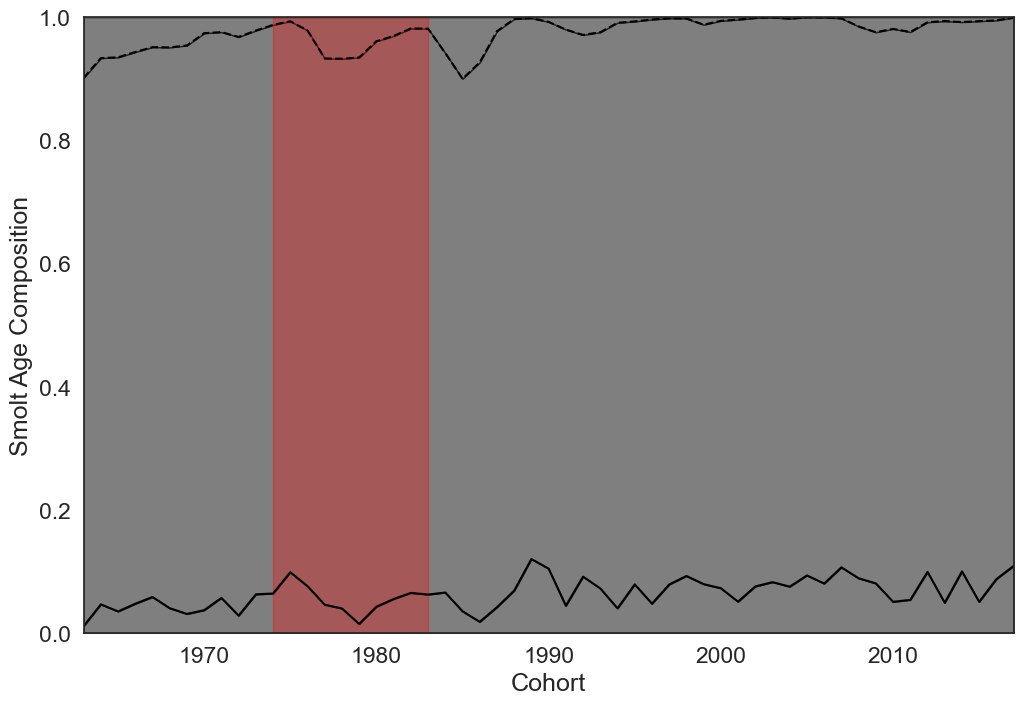

In [ ]:
plt.figure(figsize = (12, 8))
plt.stackplot(Proportions.cohort, Proportions.One_Year_Proportion, Proportions.Two_Year_Proportion, Proportions.Three_Year_Proportion, color = 'black', alpha = 0.5)
plt.plot(Proportions.cohort, Proportions.One_Year_Proportion, color = 'black')
plt.plot(Proportions.cohort, Proportions.Two_Year_Proportion+Proportions.One_Year_Proportion, color = 'black', linestyle = 'dashed')
plt.xlim(1963, 2017)
plt.ylim(0, 1)
plt.ylabel('Smolt Age Composition')
plt.xlabel('Cohort')
#plt.annotate('4.5%', xy = [1980, 1], xytext = [1964.2, 1.1], arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc', color = 'red'))

plt.axvspan(1974, 1983, color = 'red', alpha = 0.3)

#plt.savefig('Figures\Smolt_age_proportions_historical.tiff',bbox_inches='tight', dpi = 600)

# Smolt Age Composition

In [ ]:
Proportions['Smolt_Age'] = (Proportions.One_Year_Proportion*1*502 + Proportions.Two_Year_Proportion*1*(502+365) + Proportions.Three_Year_Proportion*1*(502+2*365))/365

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


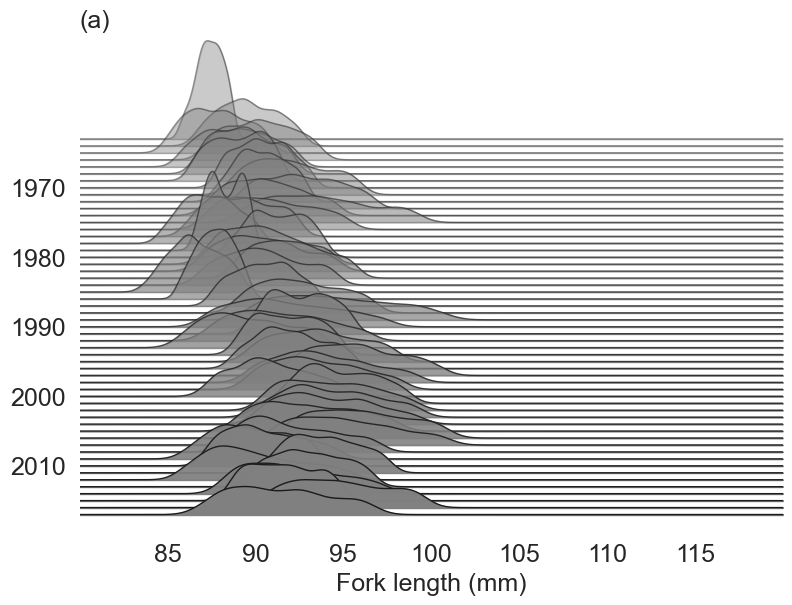

In [ ]:
labels=[y if y%10==0 else None for y in list(Distributions.cohort.unique())]
fig, axes = joyplot(Distributions[(Distributions['One_Year_Smolt'] == 1)], kind = 'kde', by="cohort", column =['length_m1'], x_range = (80, 120), labels=labels, color = 'gray', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(a)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a1_hist.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a1_hist.tiff', bbox_inches='tight', dpi = 600)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


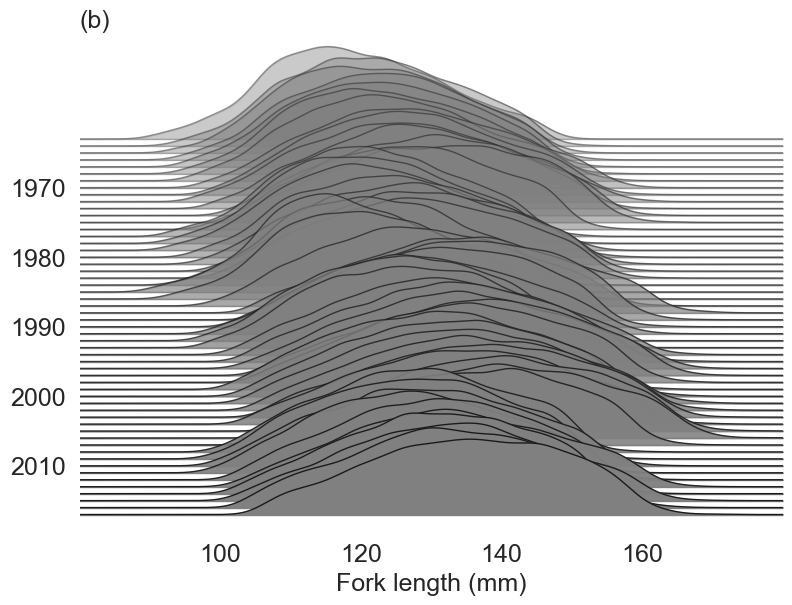

In [ ]:
labels=[y if y%10==0 else None for y in list(Distributions.cohort.unique())]
fig, axes = joyplot(Distributions[(Distributions['Two_Year_Smolt'] == 1)&(Distributions['One_Year_Smolt'] == 0)], kind = 'kde', by="cohort", column =['length_m2'], x_range = (80, 180), labels=labels, color = 'gray', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(b)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a2_hist.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a2_hist.tiff', bbox_inches='tight', dpi = 600)


# Projection
Ensemble

In [ ]:
df_forecast = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\Water_Temperature\Water_Temperature_Forecast.csv', parse_dates=['date'])
df_forecast = df_forecast.groupby(['date', 'climate_scenario', 'dayofyear']).mean().reset_index()
df_forecast = df_forecast[df_forecast.date.dt.year >= 2020]
df_forecast = freshwater_residency(2, df_forecast)
df_forecast = df_forecast[(df_forecast.cohort > 2020)&(df_forecast.cohort <= 2098)]

C:\Users\adria\AppData\Local\Temp\ipykernel_2344\2360367096.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_forecast = df_forecast.groupby(['date', 'climate_scenario', 'dayofyear']).mean().reset_index()


## Simulate the key-moments

In [ ]:
n = 10000
Projected_Decision_Distribution = []
for climate_scenario in df_forecast.climate_scenario.unique():
    for cohort in df_forecast.cohort.unique():
        XX_new = pd.DataFrame([df_forecast[(df_forecast['climate_scenario'] == climate_scenario)&(df_forecast['cohort'] == cohort)&(df_forecast['age'] == decision_age)]['dd'].mean()], columns = ['dd'])
        Simulations = pd.DataFrame(get_distribution(XX_new, beta_samp_mean = fish_gamma_log_glm.params, beta_samp_cov = fish_gamma_log_glm.cov_params(), beta_samp_scale = fish_gamma_log_glm.scale, num_samps=n), columns = ['length_d1'])
        Simulations['climate_scenario'] = climate_scenario
        Simulations['cohort'] = cohort
        Simulation = Simulations[(Simulations.length_d1 > np.quantile(Simulations.length_d1, [0.025])[0])&(Simulations.length_d1 < np.quantile(Simulations.length_d1, [0.975])[0])]
        Projected_Decision_Distribution.append(Simulation)

Projected_Decision_Distribution = pd.concat(Projected_Decision_Distribution)
Projected_Decision_Distribution = Projected_Decision_Distribution.sort_values(['cohort', 'length_d1']).reset_index(drop = True)

In [ ]:
Projected_One_Year_Distribution = []

for climate_scenario in df_forecast.climate_scenario.unique():
    for cohort in df_forecast.cohort.unique():
        XX_new = pd.DataFrame([df_forecast[(df_forecast['climate_scenario'] == climate_scenario)&(df_forecast['cohort'] == cohort)&(df_forecast['age'] == one_year_smolt_age)]['dd'].mean()], columns = ['dd'])
        Simulations = pd.DataFrame(get_distribution(XX_new, beta_samp_mean = fish_gamma_log_glm.params, beta_samp_cov = fish_gamma_log_glm.cov_params(), beta_samp_scale = fish_gamma_log_glm.scale, num_samps=n), columns = ['length_m1'])
        Simulations['climate_scenario'] = climate_scenario
        Simulations['cohort'] = cohort
        Simulation = Simulations[(Simulations.length_m1 > np.quantile(Simulations.length_m1, [0.025])[0])&(Simulations.length_m1 < np.quantile(Simulations.length_m1, [0.975])[0])]
        Projected_One_Year_Distribution.append(Simulation)

Projected_One_Year_Distribution = pd.concat(Projected_One_Year_Distribution)
Projected_One_Year_Distribution = Projected_One_Year_Distribution.sort_values(['cohort', 'length_m1']).reset_index(drop = True)


In [ ]:
Projected_Two_Year_Distribution = []

for climate_scenario in df_forecast.climate_scenario.unique():
    for cohort in df_forecast.cohort.unique():
        XX_new = pd.DataFrame([df_forecast[(df_forecast['climate_scenario'] == climate_scenario)&(df_forecast['cohort'] == cohort)&(df_forecast['age'] == two_year_smolt_age)]['dd'].mean()], columns = ['dd'])
        Simulations = pd.DataFrame(get_distribution(XX_new, beta_samp_mean = fish_gamma_log_glm.params, beta_samp_cov = fish_gamma_log_glm.cov_params(), beta_samp_scale = fish_gamma_log_glm.scale, num_samps=n), columns = ['length_m2'])
        Simulations['climate_scenario'] = climate_scenario
        Simulations['cohort'] = cohort
        Simulation = Simulations[(Simulations.length_m2 > np.quantile(Simulations.length_m2, [0.025])[0])&(Simulations.length_m2 < np.quantile(Simulations.length_m2, [0.975])[0])]
        Projected_Two_Year_Distribution.append(Simulation)

Projected_Two_Year_Distribution = pd.concat(Projected_Two_Year_Distribution)
Projected_Two_Year_Distribution = Projected_Two_Year_Distribution.sort_values(['cohort', 'length_m2']).reset_index(drop = True)


## Calculate the probabilitites

In [ ]:
Projected_Distributions = Projected_Decision_Distribution
Projected_Distributions['length_m1'] = Projected_One_Year_Distribution['length_m1']
Projected_Distributions['length_m2'] = Projected_Two_Year_Distribution['length_m2']
Projected_Distributions['Probability'] =  (1-np.exp(51.818-0.862*Projected_Distributions.length_d1)).round(2)
Projected_Distributions['One_Year_Smolt'] = [1 if i > np.random.random() else 0 for i in Projected_Distributions.Probability] # This is a Bernoulli trial -> Should draws resemble the Gaussian?
Projected_Distributions['Probability2'] = (np.exp(0.0823*Projected_Distributions.length_m2-8.8819)).round(2)
Projected_Distributions['Two_Year_Smolt'] = [1 if i > np.random.random() else 0 for i in Projected_Distributions.Probability2]
Projected_Distributions

,length_d1,climate_scenario,cohort,length_m1,length_m2,Probability,One_Year_Smolt,Probability2,Two_Year_Smolt
0,38.983100,ssp585,2021,58.320687,104.492309,-81374118.47,0,0.75,1
1,38.984070,ssp585,2021,58.326520,104.548274,-81306084.99,0,0.76,1
2,38.984108,ssp585,2021,58.357483,104.550270,-81303453.07,0,0.76,1
3,38.984856,ssp585,2021,58.367319,104.562161,-81251034.18,0,0.76,1
4,38.988731,ssp585,2021,58.371230,104.707874,-80980122.45,0,0.77,1
...,...,...,...,...,...,...,...,...,...
2222995,71.330523,ssp585,2098,115.086560,228.033614,1.00,1,19638.88,1
2222996,71.346618,ssp585,2098,115.094960,228.088882,1.00,1,19728.41,1
2222997,71.354070,ssp585,2098,115.132472,228.107677,1.00,1,19758.95,1
2222998,71.373500,ssp585,2098,115.166401,228.202640,1.00,1,19913.98,1


# Quantify the effect of temperature change length distribution in the three key-moments

In [ ]:
hist_d1_change = Distributions.groupby(['cohort']).length_d1.mean().reset_index()
hist_d1_change['length_d1_change'] = hist_d1_change.length_d1-Distributions[Distributions.cohort >= 2000].length_d1.mean()
hist_d1_change['climate_scenario'] = 'historical'

d1_change = Projected_Distributions.groupby(['cohort', 'climate_scenario']).length_d1.mean().reset_index()
d1_change['length_d1_change'] = d1_change.length_d1-Distributions[Distributions.cohort >= 2000].length_d1.mean()


hist_m1_change = Distributions.groupby(['cohort']).length_m1.mean().reset_index()
hist_m1_change['length_m1_change'] = hist_m1_change.length_m1-Distributions[Distributions.cohort >= 2000].length_m1.mean()
hist_m1_change['climate_scenario'] = 'historical'

m1_change =  Projected_Distributions.groupby(['cohort', 'climate_scenario']).length_m1.mean().reset_index()
m1_change['length_m1_change'] = m1_change.length_m1-Distributions[Distributions.cohort >= 2000].length_m1.mean()


hist_m2_change = Distributions.groupby(['cohort']).length_m2.mean().reset_index()
hist_m2_change['length_m2_change'] = hist_m2_change.length_m2-Distributions[Distributions.cohort >= 2000].length_m2.mean()
hist_m2_change['climate_scenario'] = 'historical'

m2_change = Projected_Distributions.groupby(['cohort', 'climate_scenario']).length_m2.mean().reset_index()
m2_change['length_m2_change'] = m2_change.length_m2-Distributions[Distributions.cohort >= 2000].length_m2.mean()



d1_change = pd.concat([hist_d1_change, d1_change])
m1_change = pd.concat([hist_m1_change, m1_change])
m2_change = pd.concat([hist_m2_change, m2_change])

In [ ]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


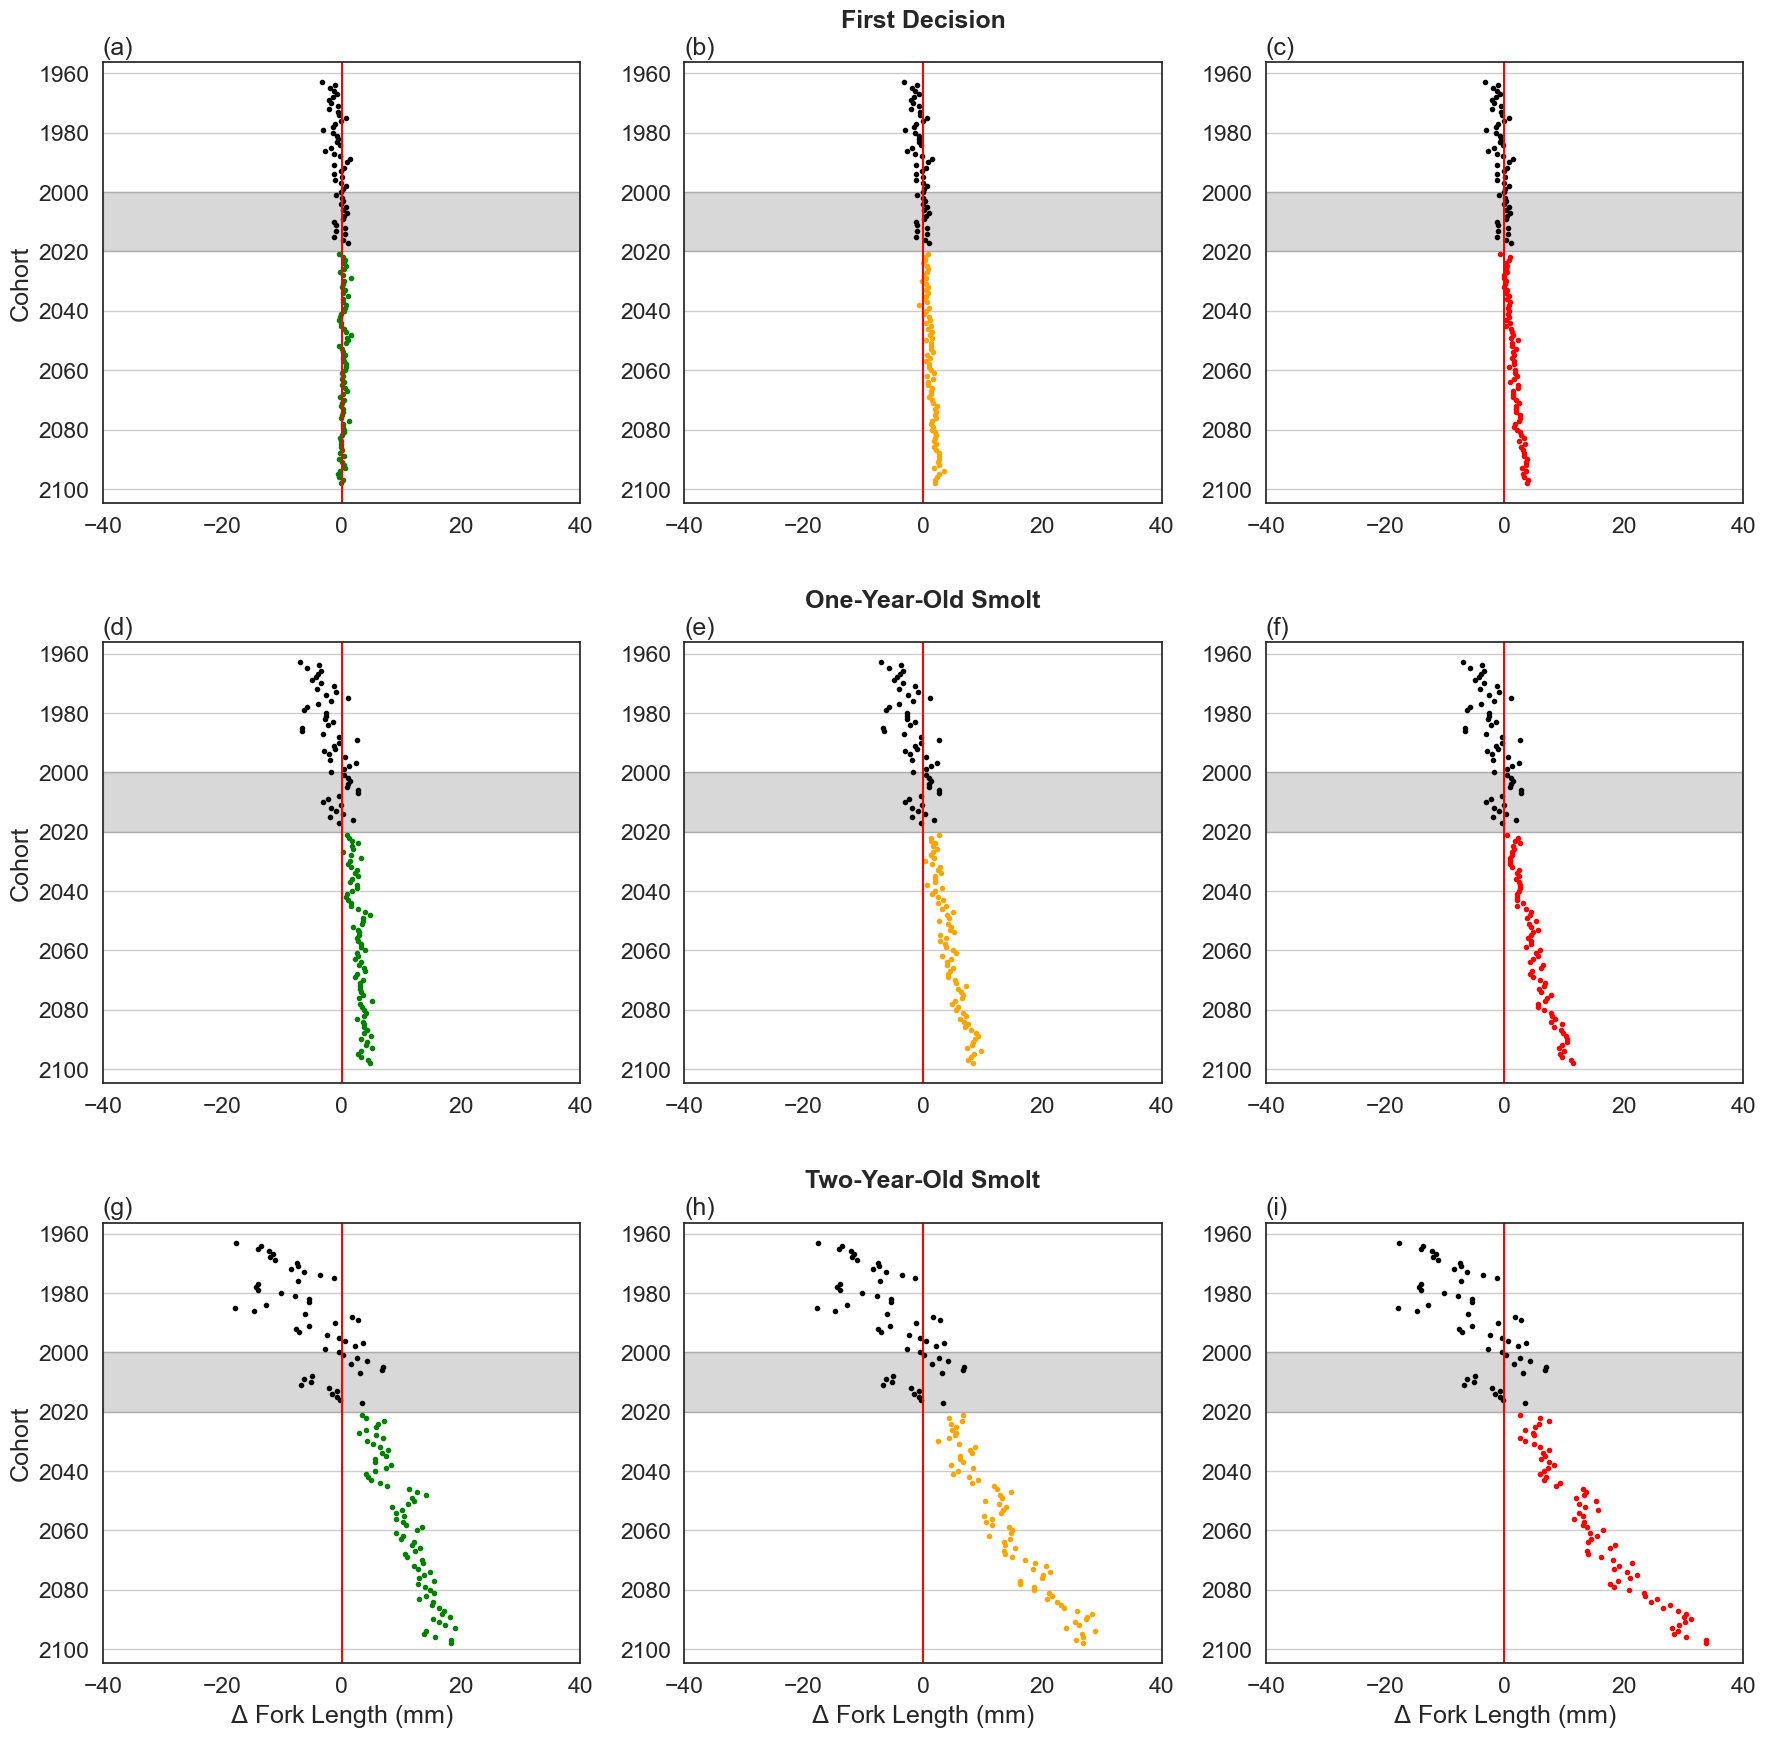

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (18, 18))
axs[0, 0].plot(d1_change[d1_change.climate_scenario == 'historical'].length_d1_change, d1_change[d1_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[0, 0].plot(d1_change[d1_change.climate_scenario == 'ssp126'].length_d1_change, d1_change[d1_change.climate_scenario == 'ssp126'].cohort, '.', color = 'green')
axs[0, 0].invert_yaxis()
axs[0, 0].set_xlim(-40, 40)
axs[0, 0].set_ylabel('Cohort')
axs[0, 0].grid(visible = True, which = 'major', axis = 'y')
axs[0, 0].axvline(0, color = 'red')
axs[0, 0].set_title('(a)', loc = 'left')
axs[0, 0].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[0, 1].plot(d1_change[d1_change.climate_scenario == 'historical'].length_d1_change, d1_change[d1_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[0, 1].plot(d1_change[d1_change.climate_scenario == 'ssp370'].length_d1_change, d1_change[d1_change.climate_scenario == 'ssp370'].cohort, '.', color = 'orange')
axs[0, 1].invert_yaxis()
axs[0, 1].set_xlim(-40, 40)
axs[0, 1].grid(visible = True, which = 'major', axis = 'y')
axs[0, 1].axvline(0, color = 'red')
axs[0, 1].set_title('(b)', loc = 'left')
axs[0, 1].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[0, 2].plot(d1_change[d1_change.climate_scenario == 'historical'].length_d1_change, d1_change[d1_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[0, 2].plot(d1_change[d1_change.climate_scenario == 'ssp585'].length_d1_change, d1_change[d1_change.climate_scenario == 'ssp585'].cohort, '.', color = 'red')
axs[0, 2].invert_yaxis()
axs[0, 2].set_xlim(-40, 40)
axs[0, 2].grid(visible = True, which = 'major', axis = 'y')
axs[0, 2].axvline(0, color = 'red')
axs[0, 2].set_title('(c)', loc = 'left')
axs[0, 2].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[1, 0].plot(m1_change[m1_change.climate_scenario == 'historical'].length_m1_change, m1_change[m1_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[1, 0].plot(m1_change[m1_change.climate_scenario == 'ssp126'].length_m1_change, m1_change[m1_change.climate_scenario == 'ssp126'].cohort, '.', color = 'green')
axs[1, 0].invert_yaxis()
axs[1, 0].set_xlim(-40, 40)
axs[1, 0].set_ylabel('Cohort')
axs[1, 0].grid(visible = True, which = 'major', axis = 'y')
axs[1, 0].axvline(0, color = 'red')
axs[1, 0].set_title('(d)', loc = 'left')
axs[1, 0].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[1, 1].plot(m1_change[m1_change.climate_scenario == 'historical'].length_m1_change, m1_change[m1_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[1, 1].plot(m1_change[m1_change.climate_scenario == 'ssp370'].length_m1_change, m1_change[m1_change.climate_scenario == 'ssp370'].cohort, '.', color = 'orange')
axs[1, 1].invert_yaxis()
axs[1, 1].set_xlim(-40, 40)
axs[1, 1].grid(visible = True, which = 'major', axis = 'y')
axs[1, 1].axvline(0, color = 'red')
axs[1, 1].set_title('(e)', loc = 'left')
axs[1, 1].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[1, 2].plot(m1_change[m1_change.climate_scenario == 'historical'].length_m1_change, m1_change[m1_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[1, 2].plot(m1_change[m1_change.climate_scenario == 'ssp585'].length_m1_change, m1_change[m1_change.climate_scenario == 'ssp585'].cohort, '.', color = 'red')
axs[1, 2].invert_yaxis()
axs[1, 2].set_xlim(-40, 40)
axs[1, 2].grid(visible = True, which = 'major', axis = 'y')
axs[1, 2].axvline(0, color = 'red')
axs[1, 2].set_title('(f)', loc = 'left')
axs[1, 2].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[2, 0].plot(m2_change[m2_change.climate_scenario == 'historical'].length_m2_change, m2_change[m2_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[2, 0].plot(m2_change[m2_change.climate_scenario == 'ssp126'].length_m2_change, m2_change[m2_change.climate_scenario == 'ssp126'].cohort, '.', color = 'green')
axs[2, 0].invert_yaxis()
axs[2, 0].set_xlim(-40, 40)
axs[2, 0].set_ylabel('Cohort')
axs[2, 0].set_xlabel(r'$\Delta$ Fork Length (mm)')
axs[2, 0].grid(visible = True, which = 'major', axis = 'y')
axs[2, 0].axvline(0, color = 'red')
axs[2, 0].set_title('(g)', loc = 'left')
axs[2, 0].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[2, 1].plot(m2_change[m2_change.climate_scenario == 'historical'].length_m2_change, m2_change[m2_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[2, 1].plot(m2_change[m2_change.climate_scenario == 'ssp370'].length_m2_change, m2_change[m2_change.climate_scenario == 'ssp370'].cohort, '.', color = 'orange')
axs[2, 1].invert_yaxis()
axs[2, 1].set_xlim(-40, 40)
axs[2, 1].set_xlabel(r'$\Delta$ Fork Length (mm)')
axs[2, 1].grid(visible = True, which = 'major', axis = 'y')
axs[2, 1].axvline(0, color = 'red')
axs[2, 1].set_title('(h)', loc = 'left')
axs[2, 1].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[2, 2].plot(m2_change[m2_change.climate_scenario == 'historical'].length_m2_change, m2_change[m2_change.climate_scenario == 'historical'].cohort, '.', color = 'black')
axs[2, 2].plot(m2_change[m2_change.climate_scenario == 'ssp585'].length_m2_change, m2_change[m2_change.climate_scenario == 'ssp585'].cohort, '.', color = 'red')
axs[2, 2].invert_yaxis()
axs[2, 2].set_xlim(-40, 40)
axs[2, 2].set_xlabel(r'$\Delta$ Fork Length (mm)')
axs[2, 2].grid(visible = True, which = 'major', axis = 'y')
axs[2, 2].axvline(0, color = 'red')
axs[2, 2].set_title('(i)', loc = 'left')
axs[2, 2].axhspan(2000, 2020, color = 'grey', alpha = 0.3)


grid = plt.GridSpec(3, 3)
create_subtitle(fig, grid[0, ::], 'First Decision')
create_subtitle(fig, grid[1, ::], 'One-Year-Old Smolt')
create_subtitle(fig, grid[2, ::], 'Two-Year-Old Smolt')
plt.tight_layout()

#plt.savefig('Figures\Smolt_age_sizechange.eps',bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Smolt_age_sizechange.tiff',bbox_inches='tight', dpi = 600)



In [ ]:
d1_change_reg = smf.ols('length_d1~cohort*climate_scenario', data = d1_change[d1_change.climate_scenario != 'historical']).fit()
m1_change_reg = smf.ols('length_m1~cohort*climate_scenario', data = m1_change[m1_change.climate_scenario != 'historical']).fit()
m2_change_reg = smf.ols('length_m2~cohort*climate_scenario', data = m2_change[m2_change.climate_scenario != 'historical']).fit()

d1_change_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              length_d1   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     222.2
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.55e-85
Time:                        16:34:01   Log-Likelihood:                -129.38
No. Observations:                 234   AIC:                             270.8
Df Residuals:                     228   BIC:                             291.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            65.1549      4.414     14.762      0.000      56.458      73.852
climate_scenario[T.ssp370]          -73.3502      6.242    -11.751      0.000     -85.649     -61.051
climate_scenario[T.ssp585]         -107.3494      6.242    -17.198      0.000    -119.648     -95.050
cohort                               -0.0062      0.002     -2.895      0.004      -0.010      -0.002
cohort:climate_scenario[T.ssp370]     0.0361      0.003     11.919      0.000       0.030       0.042
cohort:climate_scenario[T.ssp585]     0.0528      0.003     17.418      0.000       0.047       0.059
==============================================================================
Omnibus:                        1.574   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.250
Skew:                           0.107   Prob(JB):                        0.535
Kurtosis:                       3.287   Cond. No.                     7.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
print(summary_col([d1_change_reg, m1_change_reg, m2_change_reg], stars=True,float_format='%0.2f'))


                                  length_d1  length_m1  length_m2 
------------------------------------------------------------------
Intercept                         65.15***   7.23       -209.18***
                                  (4.41)     (8.74)     (21.59)   
climate_scenario[T.ssp370]        -73.35***  -125.55*** -281.23***
                                  (6.24)     (12.37)    (30.53)   
climate_scenario[T.ssp585]        -107.35*** -182.60*** -405.05***
                                  (6.24)     (12.37)    (30.53)   
cohort                            -0.01***   0.04***    0.17***   
                                  (0.00)     (0.00)     (0.01)    
cohort:climate_scenario[T.ssp370] 0.04***    0.06***    0.14***   
                                  (0.00)     (0.01)     (0.01)    
cohort:climate_scenario[T.ssp585] 0.05***    0.09***    0.20***   
                                  (0.00)     (0.01)     (0.01)    
R-squared                         0.83       0.89       0.92 

# Calculate the effect on proportion of smolt ages

In [ ]:
proportions = []

for climate_scenario in Projected_Distributions.climate_scenario.unique():
    for cohort in Projected_Distributions.cohort.unique():
        proportion = len(Projected_Distributions[(Projected_Distributions['climate_scenario'] == climate_scenario)&(Projected_Distributions['cohort'] == cohort)&(Projected_Distributions['One_Year_Smolt'] == 1)].length_d1)/len(Projected_Distributions[(Projected_Distributions['climate_scenario'] == climate_scenario)&(Projected_Distributions['cohort'] == cohort)].length_d1)
        proportion = pd.DataFrame([proportion], columns = ['Proportion'])
        proportion['climate_scenario'] = climate_scenario
        proportion['cohort'] = cohort
        proportions.append(proportion)

Projected_One_Year_Proportions = pd.concat(proportions)

proportions = []

for climate_scenario in Projected_Distributions.climate_scenario.unique():
    for cohort in Projected_Distributions.cohort.unique():
        proportion = len(Projected_Distributions[(Projected_Distributions['climate_scenario'] == climate_scenario)&(Projected_Distributions['cohort'] == cohort)&(Projected_Distributions['Two_Year_Smolt'] == 1)&(Projected_Distributions['One_Year_Smolt'] == 0)].length_m1)/len(Projected_Distributions[(Projected_Distributions['climate_scenario'] == climate_scenario)&(Projected_Distributions['cohort'] == cohort)].length_d1)
        proportion = pd.DataFrame([proportion], columns = ['Proportion'])
        proportion['climate_scenario'] = climate_scenario
        proportion['cohort'] = cohort
        proportions.append(proportion)

Projected_Two_Year_Proportions = pd.concat(proportions)

Projected_Proportions = Projected_One_Year_Proportions.copy()
Projected_Proportions.columns = ['One_Year_Proportion', 'climate_scenario', 'cohort']
Projected_Proportions['Two_Year_Proportion'] = Projected_Two_Year_Proportions['Proportion']
Projected_Proportions['Three_Year_Proportion'] = (1-(Projected_Proportions.One_Year_Proportion+Projected_Proportions.Two_Year_Proportion))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


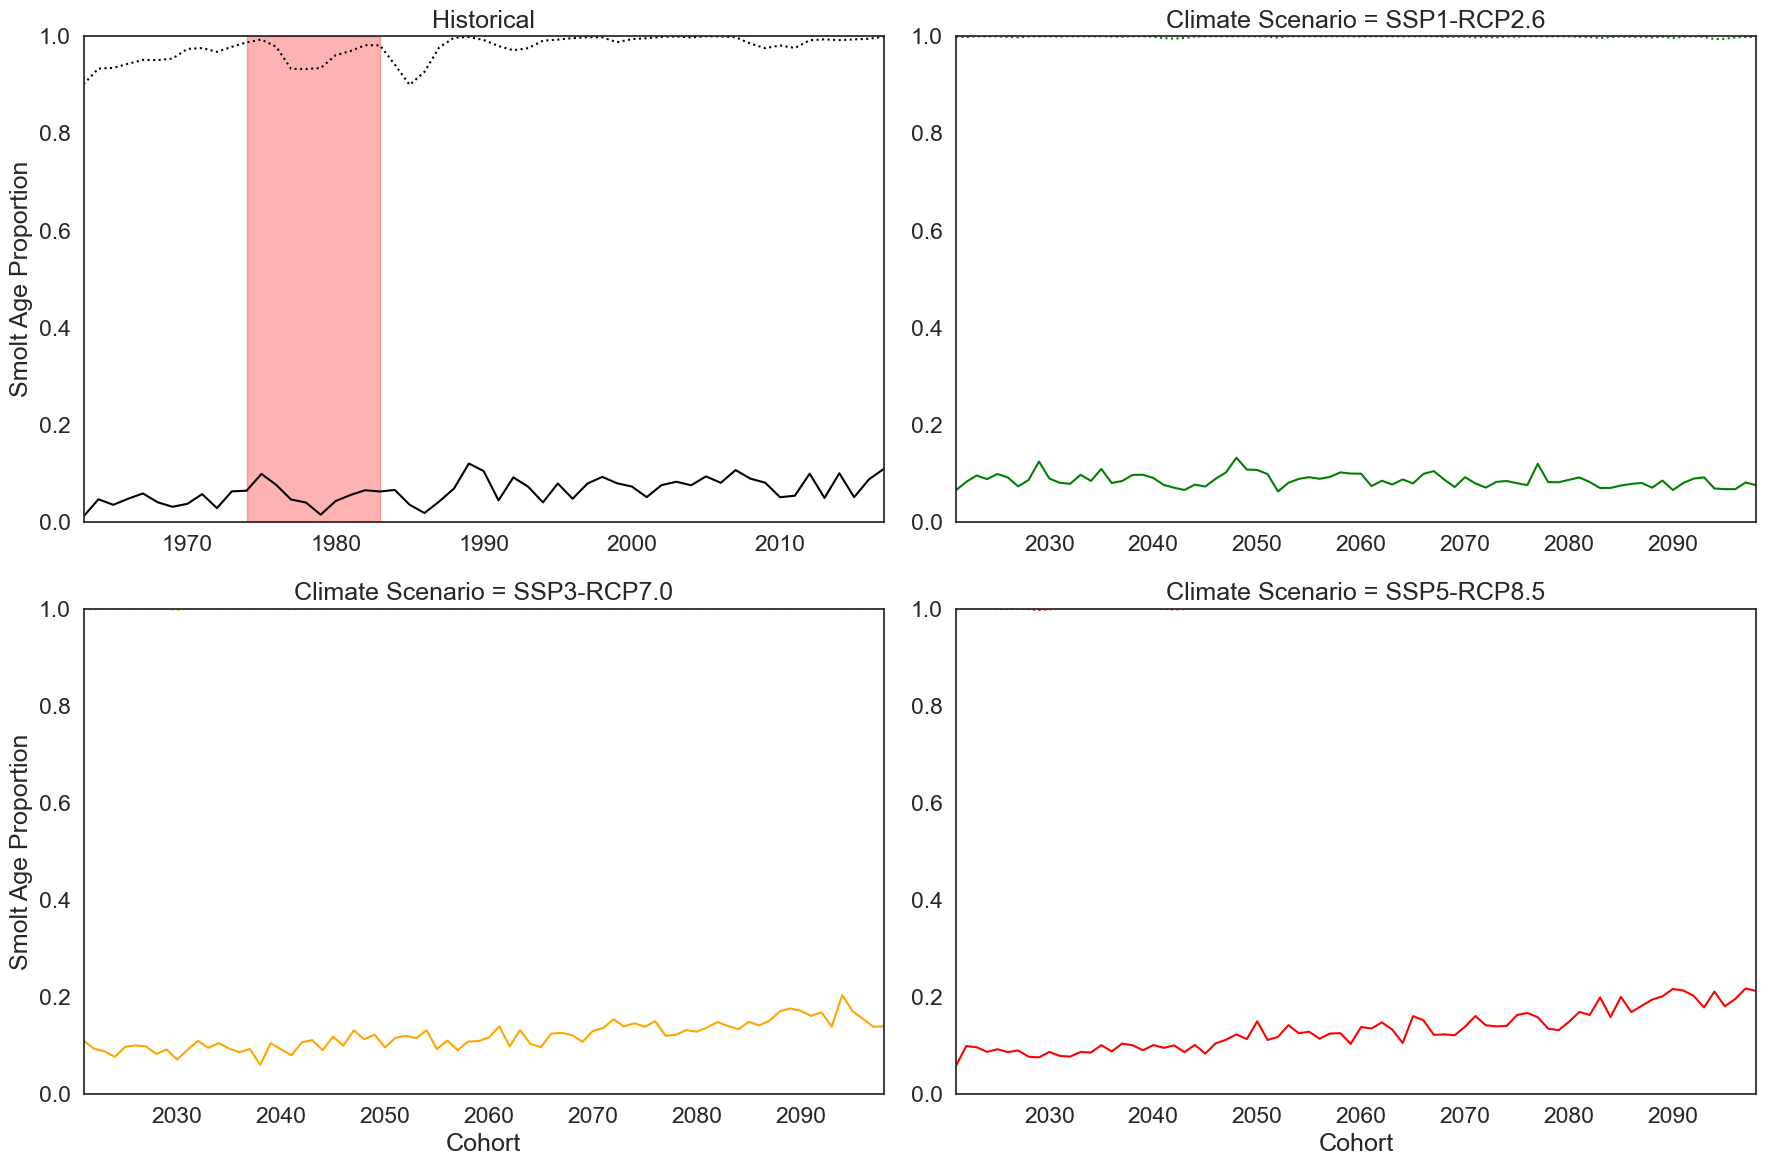

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (18, 12), )
axs[0,0].stackplot(Proportions.cohort, Proportions.One_Year_Proportion, Proportions.Two_Year_Proportion, Proportions.Three_Year_Proportion, colors = ['white', 'white'], alpha = 0.5)
axs[0,0].plot(Proportions.cohort, Proportions.One_Year_Proportion, color = 'black')
axs[0,0].plot(Proportions.cohort, Proportions.Two_Year_Proportion+Proportions.One_Year_Proportion, color = 'black', linestyle = 'dotted')
axs[0,0].set_ylim(0, 1)
axs[0,0].set_xlim(1963, 2017)
axs[0,0].set_ylabel('Smolt Age Proportion')
axs[0,0].set_title('Historical')
axs[0,0].axvspan(1974, 1983, color = 'red', alpha = 0.3)

axs[0,1].stackplot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].One_Year_Proportion, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].Two_Year_Proportion, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].Three_Year_Proportion, colors = ['white', 'white'], alpha = 0.5)
axs[0,1].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].One_Year_Proportion, color = 'green')
axs[0,1].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].Two_Year_Proportion+Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].One_Year_Proportion, linestyle = 'dotted', color = 'green')
axs[0,1].set_ylim(0, 1)
axs[0,1].set_xlim(2021, 2098)
axs[0,1].set_title('Climate Scenario = SSP1-RCP2.6')

axs[1,0].stackplot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].One_Year_Proportion, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].Two_Year_Proportion, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].Three_Year_Proportion, colors = ['white', 'white'], alpha = 0.5)
axs[1,0].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].One_Year_Proportion, color = 'orange')
axs[1,0].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].Two_Year_Proportion+Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].One_Year_Proportion, linestyle = 'dotted', color = 'orange')
axs[1,0].set_ylim(0, 1)
axs[1,0].set_xlim(2021, 2098)
axs[1,0].set_ylabel('Smolt Age Proportion')
axs[1,0].set_xlabel('Cohort')
axs[1,0].set_title('Climate Scenario = SSP3-RCP7.0')

axs[1,1].stackplot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].One_Year_Proportion, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].Two_Year_Proportion, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].Three_Year_Proportion, colors = ['white', 'white'], alpha = 0.5)
axs[1,1].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].One_Year_Proportion, color = 'red')
axs[1,1].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].cohort, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].Two_Year_Proportion+Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].One_Year_Proportion, linestyle = 'dotted', color = 'red')
axs[1,1].set_ylim(0, 1)
axs[1,1].set_xlim(2021, 2098)
axs[1,1].set_xlabel('Cohort')
axs[1,1].set_title('Climate Scenario = SSP5-RCP8.5')

fig.tight_layout()
#plt.savefig('Figures\Smolt_age_proportions.eps',bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Smolt_age_proportions.tiff',bbox_inches='tight', dpi = 600)


In [ ]:
Projected_Proportions

,One_Year_Proportion,climate_scenario,cohort,Two_Year_Proportion,Three_Year_Proportion
0,0.058000,ssp585,2021,0.940737,0.001263
0,0.099263,ssp585,2022,0.900526,0.000211
0,0.096737,ssp585,2023,0.903263,0.000000
0,0.087263,ssp585,2024,0.912632,0.000105
0,0.092632,ssp585,2025,0.906526,0.000842
...,...,...,...,...,...
0,0.204000,ssp370,2094,0.796000,0.000000
0,0.170947,ssp370,2095,0.829053,0.000000
0,0.155053,ssp370,2096,0.844947,0.000000
0,0.138842,ssp370,2097,0.861158,0.000000


In [ ]:
one_year_proportion_reg = smf.ols('One_Year_Proportion~cohort*climate_scenario', data = Projected_Proportions).fit()
one_year_proportion_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     One_Year_Proportion   R-squared:                       0.830
Model:                             OLS   Adj. R-squared:                  0.826
Method:                  Least Squares   F-statistic:                     222.9
Date:                 Wed, 07 Jun 2023   Prob (F-statistic):           1.18e-85
Time:                         16:35:44   Log-Likelihood:                 655.63
No. Observations:                  234   AIC:                            -1299.
Df Residuals:                      228   BIC:                            -1279.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.4409      0.154      2.861      0.005       0.137       0.745
climate_scenario[T.ssp370]           -2.4159      0.218    -11.084      0.000      -2.845      -1.986
climate_scenario[T.ssp585]           -3.7782      0.218    -17.334      0.000      -4.208      -3.349
cohort                               -0.0002   7.48e-05     -2.303      0.022      -0.000   -2.49e-05
cohort:climate_scenario[T.ssp370]     0.0012      0.000     11.242      0.000       0.001       0.001
cohort:climate_scenario[T.ssp585]     0.0019      0.000     17.551      0.000       0.002       0.002
==============================================================================
Omnibus:                        3.546   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.173
Skew:                           0.244   Prob(JB):                        0.205
Kurtosis:                       3.297   Cond. No.                     7.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
two_year_proportion_reg = smf.ols('Two_Year_Proportion~cohort*climate_scenario', data = Projected_Proportions).fit()
two_year_proportion_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Two_Year_Proportion   R-squared:                       0.831
Model:                             OLS   Adj. R-squared:                  0.827
Method:                  Least Squares   F-statistic:                     224.3
Date:                 Wed, 07 Jun 2023   Prob (F-statistic):           6.44e-86
Time:                         16:35:44   Log-Likelihood:                 658.90
No. Observations:                  234   AIC:                            -1306.
Df Residuals:                      228   BIC:                            -1285.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.5924      0.152      3.898      0.000       0.293       0.892
climate_scenario[T.ssp370]            2.3671      0.215     11.013      0.000       1.944       2.791
climate_scenario[T.ssp585]            3.7242      0.215     17.328      0.000       3.301       4.148
cohort                                0.0002   7.38e-05      2.111      0.036    1.04e-05       0.000
cohort:climate_scenario[T.ssp370]    -0.0012      0.000    -11.170      0.000      -0.001      -0.001
cohort:climate_scenario[T.ssp585]    -0.0018      0.000    -17.544      0.000      -0.002      -0.002
==============================================================================
Omnibus:                        4.180   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                3.861
Skew:                          -0.254   Prob(JB):                        0.145
Kurtosis:                       3.371   Cond. No.                     7.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
three_year_proportion_reg = smf.ols('Three_Year_Proportion~cohort*climate_scenario', data = Projected_Proportions).fit()
three_year_proportion_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Three_Year_Proportion   R-squared:                       0.252
Model:                               OLS   Adj. R-squared:                  0.236
Method:                    Least Squares   F-statistic:                     15.39
Date:                   Wed, 07 Jun 2023   Prob (F-statistic):           4.90e-13
Time:                           16:35:44   Log-Likelihood:                 1345.7
No. Observations:                    234   AIC:                            -2679.
Df Residuals:                        228   BIC:                            -2659.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.0332      0.008     -4.117      0.000      -0.049      -0.017
climate_scenario[T.ssp370]            0.0488      0.011      4.275      0.000       0.026       0.071
climate_scenario[T.ssp585]            0.0540      0.011      4.731      0.000       0.032       0.077
cohort                             1.659e-05   3.92e-06      4.230      0.000    8.86e-06    2.43e-05
cohort:climate_scenario[T.ssp370] -2.408e-05   5.54e-06     -4.344      0.000    -3.5e-05   -1.32e-05
cohort:climate_scenario[T.ssp585] -2.659e-05   5.54e-06     -4.796      0.000   -3.75e-05   -1.57e-05
==============================================================================
Omnibus:                      157.222   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1221.383
Skew:                           2.673   Prob(JB):                    6.03e-266
Kurtosis:                      12.833   Cond. No.                     7.03e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Calculate the effect of changes in proportion of smolt age on average population smolt age

In [ ]:
Proportions['Smolt_Age_Change'] = Proportions.Smolt_Age-Proportions[Proportions.cohort >= 2000].Smolt_Age.mean() 

Projected_Proportions['Smolt_Age'] = (Projected_Proportions.One_Year_Proportion*1*502 + Projected_Proportions.Two_Year_Proportion*1*(502+365) + Projected_Proportions.Three_Year_Proportion*1*(502+2*365))/365
Projected_Proportions['Smolt_Age_Change'] = Projected_Proportions.Smolt_Age-Proportions[Proportions.cohort <= 2000].Smolt_Age.mean() 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


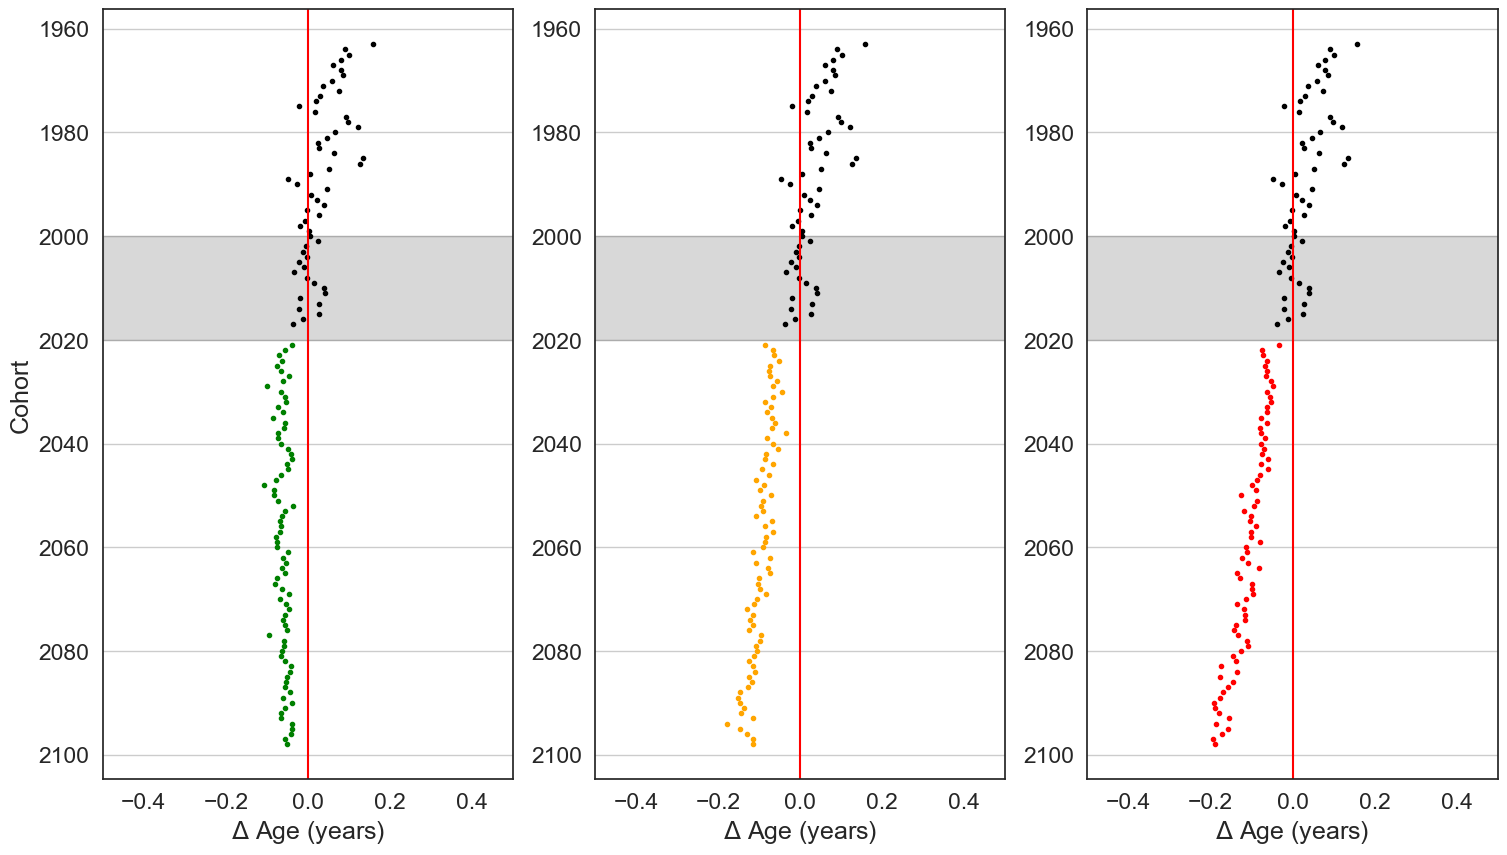

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (18, 10))
axs[0].plot(Proportions.Smolt_Age_Change, Proportions.cohort, '.', color = 'black')
axs[0].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].Smolt_Age_Change, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp126'].cohort, '.', color = 'green')
axs[0].invert_yaxis()
axs[0].set_xlim(-0.5, 0.5)
axs[0].axvline(0, color = 'red')
axs[0].set_ylabel(r'Cohort')
axs[0].set_xlabel(r'$\Delta$ Age (years)')
axs[0].grid(visible = True, which = 'major', axis = 'y')
axs[0].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[1].plot(Proportions.Smolt_Age_Change, Proportions.cohort, '.', color = 'black')
axs[1].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].Smolt_Age_Change, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp370'].cohort, '.', color = 'orange')
axs[1].invert_yaxis()
axs[1].set_xlim(-0.5, 0.5)
axs[1].axvline(0, color = 'red')
axs[1].set_xlabel(r'$\Delta$ Age (years)')
axs[1].grid(visible = True, which = 'major', axis = 'y')
axs[1].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

axs[2].plot(Proportions.Smolt_Age_Change, Proportions.cohort, '.', color = 'black')
axs[2].plot(Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].Smolt_Age_Change, Projected_Proportions[Projected_Proportions.climate_scenario == 'ssp585'].cohort, '.', color = 'red')
axs[2].invert_yaxis()
axs[2].set_xlim(-0.5, 0.5)
axs[2].axvline(0, color = 'red')
axs[2].set_xlabel(r'$\Delta$ Age (years)')
axs[2].grid(visible = True, which = 'major', axis = 'y')
axs[2].axhspan(2000, 2020, color = 'grey', alpha = 0.3)

#plt.savefig('Figures\Smolt_age_chane.eps',bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Smolt_age_chane.tiff',bbox_inches='tight', dpi = 600)


In [ ]:
pop_age_change = smf.ols('Smolt_Age~cohort*climate_scenario', data = Projected_Proportions).fit()
pop_age_change.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Ordinary least squares
==================================================================================
Model:                   OLS                   Adj. R-squared:          0.825     
Dependent Variable:      Smolt_Age             AIC:                     -1291.6277
Date:                    2023-06-07 16:35      BIC:                     -1270.8958
No. Observations:        234                   Log-Likelihood:          651.81    
Df Model:                5                     F-statistic:             220.4     
Df Residuals:            228                   Prob (F-statistic):      3.36e-85  
R-squared:               0.829                 Scale:                   0.00022873
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                          1.9012   0.1567  12.1366 0.0000  1.5926  2.2099
climate_scenario[T.ssp370]         2.4647   0.2215  11.1254 0.0000  2.0282  2.9012
climate_scenario[T.ssp585]         3.8322   0.2215  17.2981 0.0000  3.3957  4.2687
cohort                             0.0002   0.0001   2.4839 0.0137  0.0000  0.0003
cohort:climate_scenario[T.ssp370] -0.0012   0.0001 -11.2845 0.0000 -0.0014 -0.0010
cohort:climate_scenario[T.ssp585] -0.0019   0.0001 -17.5148 0.0000 -0.0021 -0.0017
----------------------------------------------------------------------------------
Omnibus:                   2.782              Durbin-Watson:                1.552 
Prob(Omnibus):             0.249              Jarque-Bera (JB):             2.416 
Skew:                      -0.222             Prob(JB):                     0.299 
Kurtosis:                  3.223              Condition No.:                703161
==================================================================================
* The condition number is large (7e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

# Projected Distributions
## RCP 2.6

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


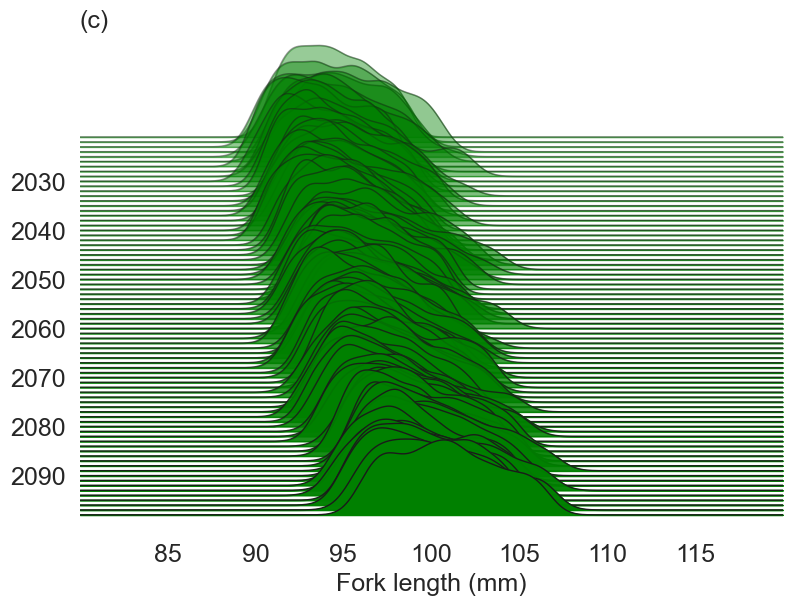

In [ ]:
labels=[y if y%10==0 else None for y in list(Projected_Distributions.cohort.unique())]
fig, axes = joyplot(Projected_Distributions[(Projected_Distributions['climate_scenario'] == 'ssp126')&(Projected_Distributions['One_Year_Smolt'] == 1)], kind = 'kde', by="cohort", column =['length_m1'], x_range = (80, 120), labels=labels, color = 'green', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(c)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a1_rcp26.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a1_rcp26.tiff', bbox_inches='tight', dpi = 600)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


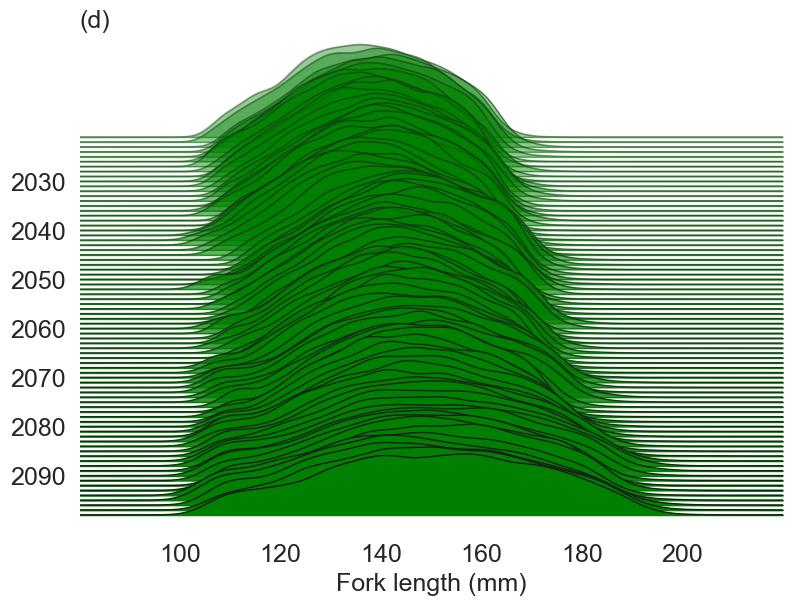

In [ ]:
labels=[y if y%10==0 else None for y in list(Projected_Distributions.cohort.unique())]
fig, axes = joyplot(Projected_Distributions[(Projected_Distributions['climate_scenario'] == 'ssp126')&(Projected_Distributions['Two_Year_Smolt'] == 1)&(Projected_Distributions['One_Year_Smolt'] == 0)], kind = 'kde', by="cohort", column =['length_m2'], x_range = (80, 220), labels=labels, color = 'green', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(d)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a2_rcp26.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a2_rcp26.tiff', bbox_inches='tight', dpi = 600)


## RCP 7.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


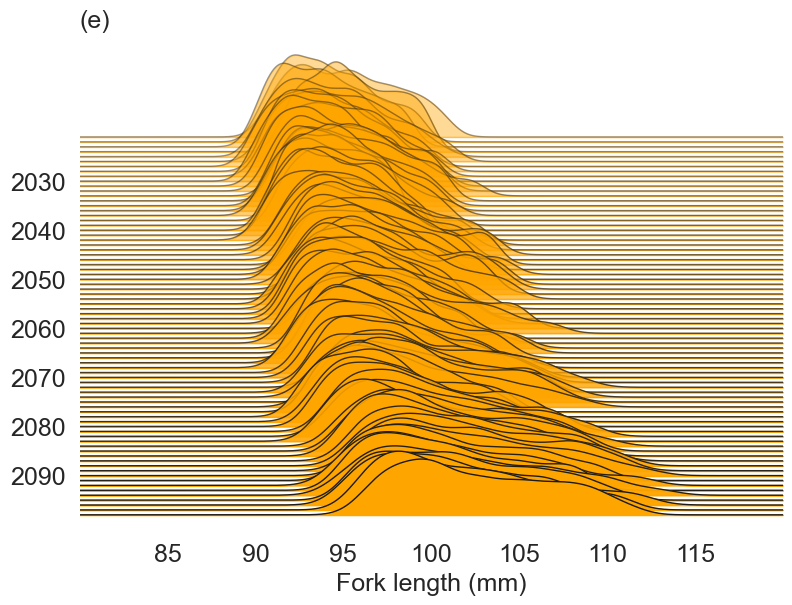

In [ ]:
labels=[y if y%10==0 else None for y in list(Projected_Distributions.cohort.unique())]
fig, axes = joyplot(Projected_Distributions[(Projected_Distributions['climate_scenario'] == 'ssp370')&(Projected_Distributions['One_Year_Smolt'] == 1)], kind = 'kde', by="cohort", column =['length_m1'], x_range = (80, 120), labels=labels, color = 'orange', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(e)', loc = 'left')


#plt.savefig('Figures\EPS\Distr_smolt_a1_rcp70.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a1_rcp70.tiff', bbox_inches='tight', dpi = 600)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


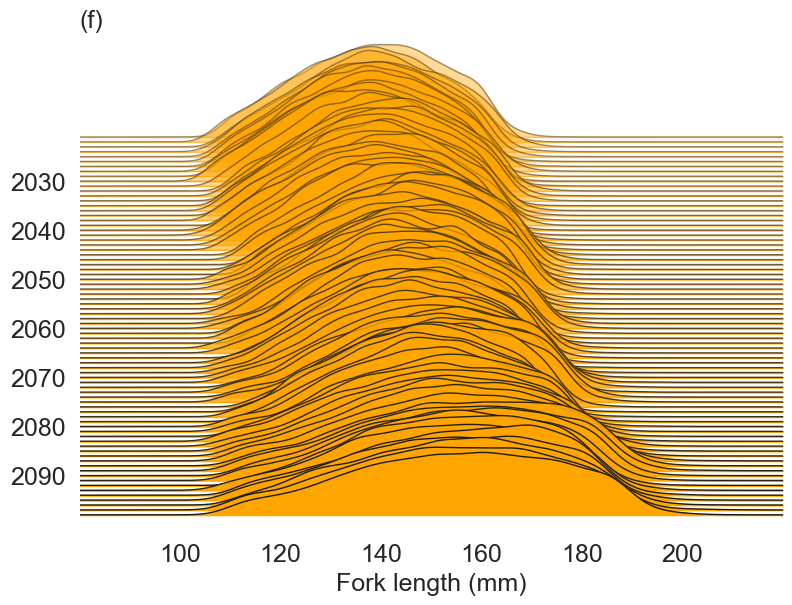

In [ ]:
labels=[y if y%10==0 else None for y in list(Projected_Distributions.cohort.unique())]
fig, axes = joyplot(Projected_Distributions[(Projected_Distributions['climate_scenario'] == 'ssp370')&(Projected_Distributions['Two_Year_Smolt'] == 1)&(Projected_Distributions['One_Year_Smolt'] == 0)], kind = 'kde', by="cohort", column =['length_m2'], x_range = (80, 220), labels=labels, color = 'orange', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(f)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a2_rcp70.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a2_rcp70.tiff', bbox_inches='tight', dpi = 600)


## RCP 8.5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


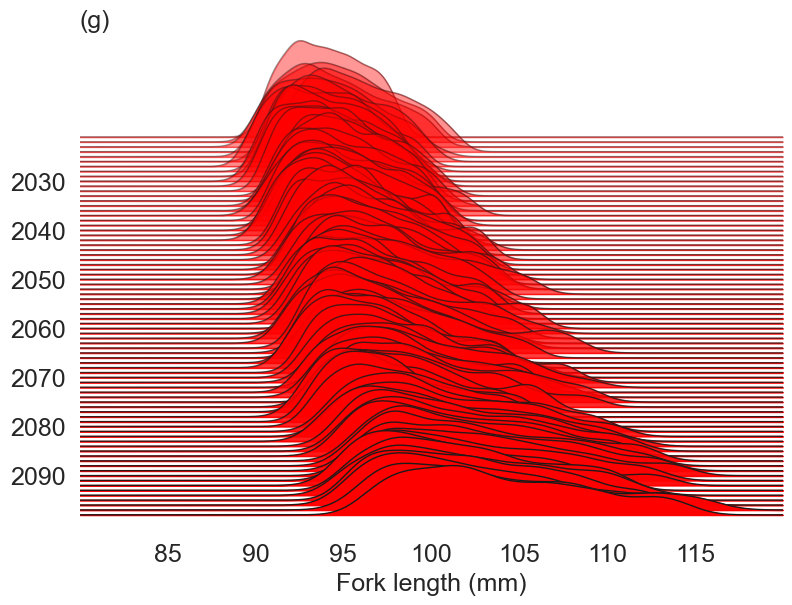

In [ ]:
labels=[y if y%10==0 else None for y in list(Projected_Distributions.cohort.unique())]
fig, axes = joyplot(Projected_Distributions[(Projected_Distributions['climate_scenario'] == 'ssp585')&(Projected_Distributions['One_Year_Smolt'] == 1)], kind = 'kde', by="cohort", column =['length_m1'], x_range = (80, 120), labels=labels, color = 'red', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(g)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a1_rcp85.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a1_rcp85.tiff', bbox_inches='tight', dpi = 600)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


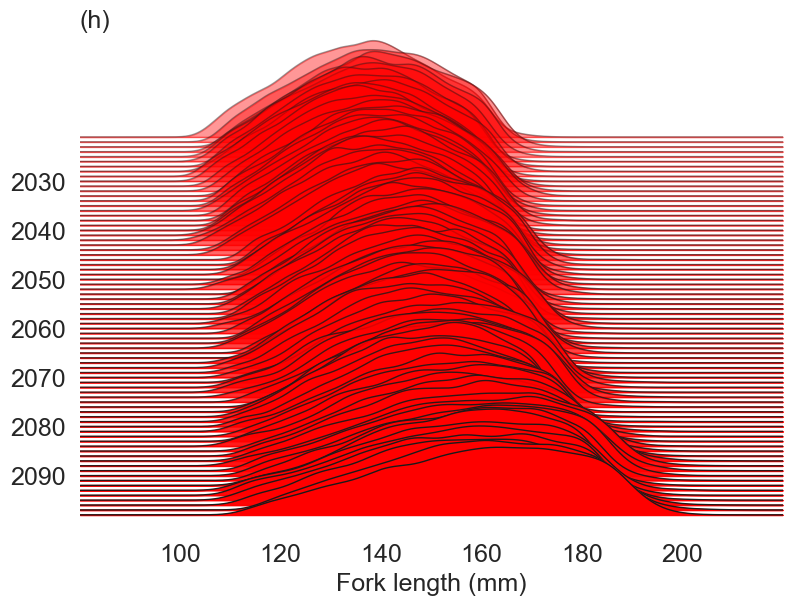

In [ ]:
labels=[y if y%10==0 else None for y in list(Projected_Distributions.cohort.unique())]
fig, axes = joyplot(Projected_Distributions[(Projected_Distributions['climate_scenario'] == 'ssp585')&(Projected_Distributions['Two_Year_Smolt'] == 1)&(Projected_Distributions['One_Year_Smolt'] == 0)], kind = 'kde', by="cohort", column =['length_m2'], x_range = (80, 220), labels=labels, color = 'red', 
                          grid="y", linewidth=1, legend=False, figsize=(4.134*2,2.92325*2), fade = True)

plt.xlabel('Fork length (mm)')
plt.title('(h)', loc = 'left')

#plt.savefig('Figures\EPS\Distr_smolt_a2_rcp85.eps', bbox_inches='tight', dpi = 600)
#plt.savefig('Figures\Distr_smolt_a2_rcp85.tiff', bbox_inches='tight', dpi = 600)
